# Carregamento dos dados
Vamos utilizar a biblioteca ``datasets`` do ``HuggingFace`` para carregar um dataset de notícias em Português BR.

In [1]:
! pip install datasets

In [2]:
from datasets import load_dataset

dataset = load_dataset("divergente/wikitext-ptbr-1", "default")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Utilizaremos 200 textos do dataset para realizar o fine-tuning do modelo já treinado BERTimbau.

In [3]:
import pandas as pd
df = pd.DataFrame(data=dataset['train'][0:200]['text'], columns=["text"])
df.head()

,text
0,Formação estrelar na Grande Nuvem de Magalhães...
1,"Fondachelli Fantina, Sicília. Inicialmente, a ..."
2,Nebulosa planetária de Formiga. A ejecção de g...
3,Astronomia extragaláctica exemplo de lente gr...
4,A radioastronomia estuda a radiação com compri...


# Fine tuning do modelo BERTimbau

Realizaremos então o fine-tuning do modelo BERTimbau utilizando a GPU do Google Colab.

In [4]:
import torch
from torch.optim import AdamW
from transformers import AutoTokenizer, AutoModelForMaskedLM
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import random

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

tokenizer = AutoTokenizer.from_pretrained("neuralmind/bert-base-portuguese-cased")
model = AutoModelForMaskedLM.from_pretrained("neuralmind/bert-base-portuguese-cased").to(device)

epochs = 15
train_loss_set = []
valid_loss_set = []

def encode_text_with_masks(df, mask_prob=0.15):
    input_ids = []
    attention_masks = []

    for text in df['text']:
        tokens = tokenizer.tokenize(text)
        mask_indices = [i for i, token in enumerate(tokens) if random.random() < mask_prob]

        for mask_index in mask_indices:
            if mask_index < len(tokens) - 1:
                tokens[mask_index] = '[MASK]'

        masked_text = ' '.join(tokens)
        encoded_dict = tokenizer.encode_plus(
                            masked_text,
                            add_special_tokens=True,
                            max_length=256,
                            padding='max_length',
                            truncation=True,
                            return_attention_mask=True,
                            return_tensors='pt'
                        )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    return input_ids, attention_masks

input_ids, attention_masks = encode_text_with_masks(df)

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)

train_inputs, validation_inputs, train_masks, validation_masks = train_test_split(input_ids, attention_masks, random_state=42, test_size=0.3)

train_data = TensorDataset(train_inputs, train_masks)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=32)

validation_data = TensorDataset(validation_inputs, validation_masks)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=32)

optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

for epoch_i in tqdm(range(0, epochs)):
    model.train()
    total_train_loss = 0
    total_train_accuracy = 0
    for step, batch in enumerate(train_dataloader):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        model.zero_grad()
        outputs = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask,
                        labels=b_input_ids)

        loss = outputs.loss
        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()


    avg_train_loss = total_train_loss / len(train_dataloader)
    train_loss_set.append(avg_train_loss)

    model.eval()
    total_valid_accuracy = 0
    total_valid_loss = 0
    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        with torch.no_grad():
            outputs = model(b_input_ids,
                            token_type_ids=None,
                            attention_mask=b_input_mask,
                            labels=b_input_ids)

        loss = outputs.loss
        total_valid_loss += loss.item()

    avg_valid_loss = total_valid_loss / len(validation_dataloader)
    valid_loss_set.append(avg_valid_loss)

torch.save(model.state_dict(), 'model_fine_tuned.pt')



/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identica

## Loss
Após o fine-tuning, podemos observar a perda durante o treinamento utilizando nossos dados.

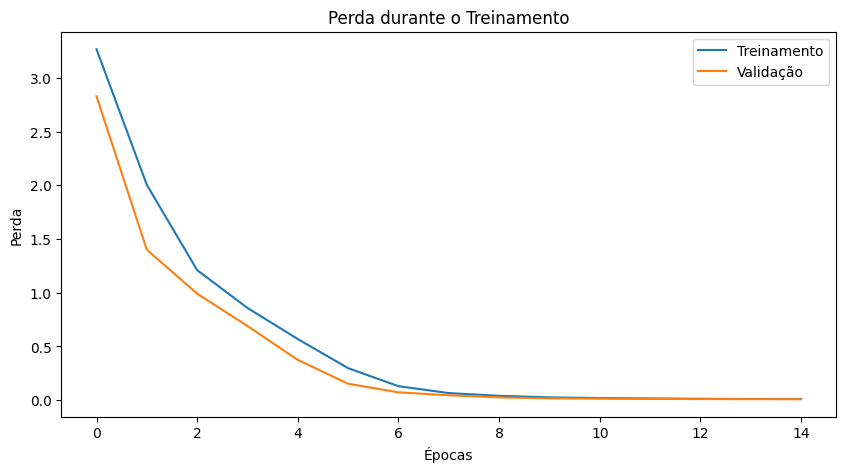

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_loss_set, label="Treinamento")
plt.plot(valid_loss_set, label="Validação")
plt.title("Perda durante o Treinamento")
plt.xlabel("Épocas")
plt.ylabel("Perda")
plt.legend()
plt.show()


# Testando o modelo

In [6]:
model = AutoModelForMaskedLM.from_pretrained("neuralmind/bert-base-portuguese-cased")

model.load_state_dict(torch.load('model_fine_tuned.pt'))

model.eval()

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29794, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_a

In [7]:
model_pretrained = AutoModelForMaskedLM.from_pretrained("neuralmind/bert-base-portuguese-cased")
model = AutoModelForMaskedLM.from_pretrained("neuralmind/bert-base-portuguese-cased")

print("Modelos são iguais?", model_pretrained.state_dict == model.state_dict)

model.load_state_dict(torch.load('model_fine_tuned.pt'))

model.eval()
model_pretrained.eval()

text = "Aqui está um exemplo de texto onde queremos prever uma [MASK]."

encoded_input = tokenizer(text, return_tensors="pt")

with torch.no_grad():
    predictions_pretrained = model_pretrained(**encoded_input)

with torch.no_grad():
    predictions = model(**encoded_input)


mask_token_index = torch.where(encoded_input["input_ids"] == tokenizer.mask_token_id)[1]

top_n = 3

top_n_tokens_pretrained = predictions_pretrained.logits[0, mask_token_index].topk(top_n).indices[0]

top_n_tokens = predictions.logits[0, mask_token_index].topk(top_n).indices[0]

predicted_tokens_pretrained = [tokenizer.decode([token_id]) for token_id in top_n_tokens_pretrained]

predicted_tokens = [tokenizer.decode([token_id]) for token_id in top_n_tokens]


print(f"Texto com a máscara: {text}")
print(f"Top {top_n} predições para a palavra mascarada (modelo pré treinado):")
for i, token in enumerate(predicted_tokens_pretrained, 1):
    print(f"{i}: {token}")

print(f"Top {top_n} predições para a palavra mascarada (modelo fine-tuned):")
for i, token in enumerate(predicted_tokens, 1):
    print(f"{i}: {token}")


Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForM

Modelos são iguais? False
Texto com a máscara: Aqui está um exemplo de texto onde queremos prever uma [MASK].
Top 3 predições para a palavra mascarada (modelo pré treinado):
1: situação
2: tempestade
3: data
Top 3 predições para a palavra mascarada (modelo fine-tuned):
1: situação
2: emergência
3: ação
